In [1]:
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2

In [2]:
"""
Code to load model from here:
https://wandb.ai/jack-morris/emb-inv-1/runs/dc72e8b9c01bd27b0ed1c2def90bcee5/overview?workspace=user-jxmorris12

TODO: abstract this into analyze_utils function like load_trainer_from_checkpoint.
"""
import os
import shlex

import datasets
import torch
from transformers import AutoTokenizer, HfArgumentParser, set_seed
from transformers.trainer_utils import get_last_checkpoint

from collator import CustomCollator
from data_helpers import load_dpr_corpus, NQ_DEV, NQ_TRAIN
from models import load_encoder_decoder, load_embedder_and_tokenizer, InversionModel
from run_args import ModelArguments, DataTrainingArguments, TrainingArguments
from tokenize_data import tokenize_function
from trainer import InversionTrainer

#############################################################################

WANDB_ARGS_STR = '--per_device_train_batch_size 128 --per_device_eval_batch_size 128 --max_seq_length 128 --model_name_or_path t5-base --embedder_model_name gtr_base --num_repeat_tokens 16 --embedder_no_grad True --exp_group_name mar17-baselines --learning_rate 0.0003 --freeze_strategy none --embedder_fake_with_zeros False --use_frozen_embeddings_as_input False --num_train_epochs 24 --max_eval_samples 500 --eval_steps 25000 --warmup_steps 100000 --bf16=1 --use_wandb=1'
args = shlex.split(WANDB_ARGS_STR)

parser = HfArgumentParser((ModelArguments, DataTrainingArguments, TrainingArguments))
model_args, data_args, training_args = parser.parse_args_into_dataclasses(args=args)

checkpoint = '/home/jxm3/research/retrieval/inversion/saves/c9a30cba01655d513e46040f949f6da7'
training_args = torch.load(os.path.join(checkpoint, 'training_args.bin'))
training_args.use_wandb = False

set_seed(training_args.seed)

#############################################################################
tokenizer = AutoTokenizer.from_pretrained(
    model_args.model_name_or_path,
    padding=True,
    truncation='max_length',
    max_length=model_args.max_seq_length,
)
embedder, embedder_tokenizer = load_embedder_and_tokenizer(
    name=model_args.embedder_model_name
)
model = InversionModel(
    embedder=embedder,
    embedder_tokenizer=embedder_tokenizer,
    tokenizer=tokenizer,
    encoder_decoder=load_encoder_decoder(
        model_name=model_args.model_name_or_path
    ),
    num_repeat_tokens=model_args.num_repeat_tokens,
    embedder_no_grad=model_args.embedder_no_grad,
    freeze_strategy=model_args.freeze_strategy,
)
model._keys_to_ignore_on_save = []

#############################################################################

text_column_name = "text"

raw_datasets = datasets.DatasetDict({
    "train": load_dpr_corpus(NQ_TRAIN),
    "validation": load_dpr_corpus(NQ_DEV),
})
column_names = list(raw_datasets["train"].features)
tokenized_datasets = raw_datasets.map(
    tokenize_function(tokenizer, embedder_tokenizer, text_column_name, model_args.max_seq_length),
    batched=True,
    num_proc=training_args.dataloader_num_workers,
    remove_columns=column_names,
    load_from_cache_file=not data_args.overwrite_cache,
    desc="Running tokenizer on dataset",
)
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["validation"]

if data_args.max_eval_samples is not None:
    max_eval_samples = min(len(eval_dataset), data_args.max_eval_samples)
    eval_dataset = eval_dataset.select(range(max_eval_samples))


#############################################################################

# Initialize our Trainer
trainer = InversionTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=CustomCollator(tokenizer=tokenizer),
)

# *** Evaluation ***
checkpoint = get_last_checkpoint('/home/jxm3/research/retrieval/inversion/saves/8631b1c05efebde3077d16c5b99f6d5e/dc72e8b9c01bd27b0ed1c2def90bcee5') # a checkpoint
trainer._load_from_checkpoint(checkpoint)

os.environ["WANDB_DISABLED"] = "true"
max_eval_samples = data_args.max_eval_samples if data_args.max_eval_samples is not None else len(eval_dataset)

metrics = trainer.evaluate()
metrics["eval_samples"] = min(max_eval_samples, len(eval_dataset))

print("metrics:", metrics)

2023-04-01 12:11:29.104176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 12:11:38.326096: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-01 12:11:45.083878: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-01 12:12:20.189005: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Set train_args.dataloader_num_workers = 4


/home/jxm3/.conda/envs/torch/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Some weights of T5Model were not initialized from the model checkpoint at sentence-transformers/gtr-t5-base and are newly initialized: ['decoder.block.10.layer.2.DenseReluDense.wi.weight', 'decoder.block.8.layer.2.layer_norm.w

generating from val:   0%|                                                                                              | 0/62 [00:00<?, ?it/s]/home/jxm3/.conda/envs/torch/lib/python3.9/site-packages/torch/_inductor/compile_fx.py:90: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Alonzo Mourning Alonzo Harding Mourning Jr. (born December 19, 1969) is an American retired professional basketball player who played in the National Basketball Association (NBA). He was a center and left guard for the Miami Heat, Los Angeles Lakers, and Atlanta Hawks. After playing college basketball at the University of Arizona, Mourning became known as "Motionary" after a ten-year career in which he averaged a career-high.276. Mourning was named to the All-NBA Second Team twice
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourning played at center. Following his college basketball career at Georgetown University, his tenacity on defense twice earned him NBA Defensive Player of the Year Award and perennially placed him on the NBA All-Defensive Team. Mourning made a comeback after undergoing a kidn

metrics: {'eval_loss': 2.31308650970459, 'eval_bleu_score': 11.856027778443329, 'eval_accuracy': 0.5111202116935484, 'eval_perplexity': 10.105567501104156, 'eval_runtime': 234.8872, 'eval_samples_per_second': 2.129, 'eval_steps_per_second': 0.268, 'eval_samples': 500}


In [46]:
from tqdm.notebook import trange

trainer.args.per_device_eval_batch_size = 8

d = trainer.get_eval_dataloader()
batch = next(iter(d))
batch['input_ids'].shape

torch._dynamo.config.verbose = True
trainer.model.eval()

gen_kwargs = trainer.gen_kwargs
gen_kwargs["temperature"] = 1e-18
gen_kwargs["do_sample"] = True

torch.set_grad_enabled(False)

input_embs = trainer.model.call_embedding_model(
    input_ids=batch['embedder_input_ids'].cuda(),
    attention_mask=batch['embedder_attention_mask'].cuda(),
)

all_data = []
outputs = trainer.model.generate(
    inputs={k: v.cuda() for k,v in batch.items()},
    generation_kwargs=gen_kwargs
)[:, 1:]

for prefix_length in trange(1, outputs.shape[1]):# 1, outputs.shape[1]):
    # pred prefix
    prefixes = outputs[:, :prefix_length]
    # add eos token
    prefixes = torch.cat((prefixes, torch.tensor([[model.embedder_tokenizer.eos_token_id]], device=prefixes.device).repeat(len(prefixes), 1)), dim=1)
    prefix_embs = trainer.model.call_embedding_model(
        input_ids=prefixes,
        attention_mask=torch.ones_like(prefixes),
    )
    prefix_sims = torch.nn.CosineSimilarity(dim=1)(input_embs, prefix_embs)
    all_data.extend(
        [[j, p.cpu().tolist(), sim.cpu().item(), prefix_length, "predicted"] for j, (p, sim) in enumerate(zip(prefixes, prefix_sims))]
    )
    # true prefix
    true_prefixes = batch['embedder_input_ids'][:, :prefix_length].cuda()
    # add eos token
    true_prefixes = torch.cat((true_prefixes, torch.tensor([[model.embedder_tokenizer.eos_token_id]], device=prefixes.device).repeat(len(true_prefixes), 1)), dim=1)
    true_embs = trainer.model.call_embedding_model(
        input_ids=true_prefixes,
        attention_mask=torch.ones_like(true_prefixes),
    )
    true_sims = torch.nn.CosineSimilarity(dim=1)(input_embs, true_embs)
    all_data.extend(
        [[j, p.cpu().tolist(), sim.cpu().item(), prefix_length, "true"] for j, (p, sim) in enumerate(zip(prefixes, true_sims))]
    )

  0%|          | 0/126 [00:00<?, ?it/s]

In [79]:
pd.set_option('display.max_colwidth', None)
tdf = pd.DataFrame(
    zip(model.embedder_tokenizer.batch_decode(batch['embedder_input_ids']), model.embedder_tokenizer.batch_decode(outputs)),
    columns=['original', 'reconstructed']
)
tdf

,original,reconstructed
0,"Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed ""Zo"", Mourning played at center. Following his college basketball career at Georgetown University, his tenacity on defense twice earned him NBA Defensive Player of the Year Award and perennially placed him on the NBA All-Defensive Team. Mourning made a comeback after undergoing a kidney transplant</s>","Alonzo Mourning Alonzo Harding Mourning Jr. (born December 19, 1969) is an American retired professional basketball player who played in the National Basketball Association (NBA). He was a center and left guard for the Miami Heat, Los Angeles Lakers, and Atlanta Hawks. After playing college basketball at the University of Arizona, Mourning became known as ""Motionary"" after a ten-year career in which he averaged a career-high.276. Mourning was named to the All-NBA Second Team twice"
1,"Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs went from unhappy to joyful and happy after the shocks stopped altogether. In the opponent-process model, this is the result of a shift over time from fear to pleasure in the fear-pleasure emotion pair. Another example of opponent processes is the use of nicotine. In the terms of Hedonism, one process (the initial process) is a hedonic ""reaction"" that is prompted by the use of nicotine. The user gains</s>","the opponent's behavior, the opponent's behavior was a result of the opponent's behavior. The dog and smoker were able to use the process to create a new state of equilibrium, which was a result of the aforementioned process. The dog and smoker were able to use the process to create a new state of equilibrium. The Hedonism process is an example of a symbiotic relationship between axons and axons. The symbiotic relationship between axons and axons is called the"
2,"Nosei Glacier Nosei Glacier (, ‘Lednik Nosei’ <unk>'led-nik 'no-se-i<unk>) is the steep 1.3 km long and 1 km wide glacier draining the southeast slopes of Imeon Range on Smith Island in the South Shetland Islands, Antarctica. It is situated east of upper Dalgopol Glacier, southeast of Kongur Glacier and southwest of Ritya Glacier, flows eastwards from a part of the main crest between Mezek Peak and Mount Christ</s>","Nosei Glacier Nosei Glacier (, ‘Nosei Glacier’ <unk>'n<unk>s' 'n<unk>s' 'n<unk>s' 'n<unk>s' 'n<unk>s' 'n<unk>s' 'n<unk>s' 'n<unk>s' 'n<unk>s') is a glacier located in the south-central part of Smith Island in the South Shetland Islands, Antarctica. It rises to 2,030 m above sea level and flows northwestward through the southern slopes of"
3,"drama ""St. Elsewhere"", a likeable and humorous psychiatric patient, and Mr. Herd, a patient of psychologist Bob Hartley on ""The Bob Newhart Show"", a long-running CBS situation comedy. He played Mr. Belding in the original pilot of the series ""Good Morning Miss Bliss"" but was subsequently replaced by Dennis Haskins. Clark also played Roger Barton on an episode of "" The Golden Girls"", and played Joe Carruthers, the man who later becomes Santa Claus, in the holiday comedy film ""Ern</s>","""The Bob Newhart Show"", as Mr. Rogers, a snobbish, snobbish, and snobbish, alcoholic, and alcoholic, who is the only person in the world who can understand the difference between the two. He also played Colonel Belding on the sitcom ""The Golden Girls"" (as Bob Stallworth), and played Bob's replacement, Mrs. Hartley, on the television series ""All That"". He also appeared in the pilot episode of ""The Andy Griffith Show"" as the recurring character"
4,"killed in the coup, and Zheng Yin, as their associate, was demoted to be publics works officer at Xuan Prefecture (<unk>, roughly modern Xuancheng, Anhui). Once there, he was accused of receiving bribes, a

In [47]:
true_prefixes

tensor([[  901,    32, 20547,  ...,     9, 11546,     1],
        [   37,    29,     6,  ...,    37,  1139,     1],
        [  465,     7,    15,  ...,    11,  7964,     1],
        ...,
        [  799,    53,    45,  ...,   518,  1092,     1],
        [   38,     3, 15329,  ...,  1871,    31,     1],
        [   12,   240,   147,  ...,    11,     8,     1]], device='cuda:0')

In [48]:
torch.cat((prefixes, torch.tensor([[model.embedder_tokenizer.eos_token_id]], device=prefixes.device).repeat(len(prefixes), 1)), dim=1).shape

torch.Size([8, 128])

In [49]:
true_prefixes[0]

tensor([  901,    32, 20547,   283,  1211,    29,    53,   901,    32, 20547,
         6424,    53,   283,  1211,    29,    53,  8206,     5,    41,  7473,
         2083,  9478,  7434,    61,    19,    46,   797, 10611,   771,  8498,
         1959,     6,   113,  1944,   167,    13,   112,   627,    18,  1201,
          868, 21249,  2125,    41,   567,  4882,    61,  1415,    21,     8,
         8327,  7862,     5,  7486,  4350,    26,    96,   956,    32,  1686,
          283,  1211,    29,    53,  1944,    44,  1530,     5,  6851,   112,
         1900,  8498,  1415,    44, 29218,   636,     6,   112,     3,   324,
            9,  6726,    30,  4453,  4394,  4964,   376, 14512,   374, 23039,
           15, 12387,    13,     8,  2929,  3677,    11, 24999,   120,  2681,
          376,    30,     8, 14512,   432,    18,  2962, 23039,    15,  2271,
            5,   283,  1211,    29,    53,   263,     3,     9,   369,  1549,
          227,     3, 22725,     3,     9, 11546,     1], device

In [50]:
import pandas as pd

df = pd.DataFrame(all_data, columns=["i", "prefix", "sim", "prefix_length", "ptype"])
df.head()

,i,prefix,sim,prefix_length,ptype
0,0,"[901, 1]",0.283099,1,predicted
1,1,"[8, 1]",0.113453,1,predicted
2,2,"[465, 1]",0.120502,1,predicted
3,3,"[96, 1]",0.146641,1,predicted
4,4,"[21761, 1]",0.200188,1,predicted


In [51]:
df.tail()

,i,prefix,sim,prefix_length,ptype
2011,3,"[96, 634, 5762, 368, 13626, 3111, 1686, 38, 13...",0.999745,126,true
2012,4,"[21761, 12, 2318, 32, 63, 1468, 6, 213, 3, 88,...",0.999884,126,true
2013,5,"[126, 2233, 5932, 7, 5, 37, 126, 2233, 5932, 7...",0.999588,126,true
2014,6,"[3, 51, 6770, 19, 10431, 13, 3, 9, 1196, 13, 3...",0.999515,126,true
2015,7,"[12, 169, 8, 579, 13, 8, 480, 31, 202, 18, 434...",0.999894,126,true


<AxesSubplot:xlabel='prefix_length', ylabel='sim'>

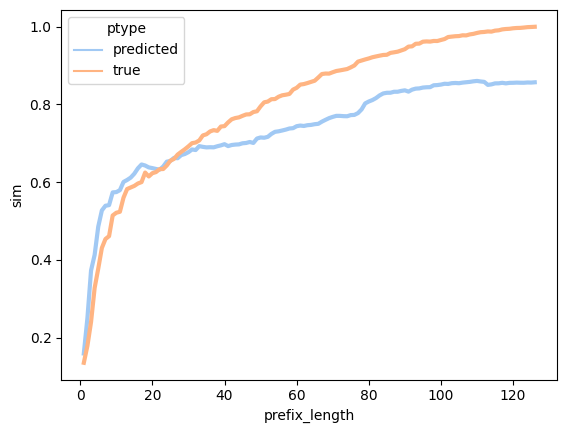

In [71]:
import seaborn as sns
pdf = df.groupby(["prefix_length", "ptype"]).mean().reset_index()

sns.set_palette("pastel", 2)
sns.lineplot(data=pdf, x="prefix_length", y="sim", hue="ptype", linewidth=3)

In [58]:
df["i"].value_counts()

0    252
1    252
2    252
3    252
4    252
5    252
6    252
7    252
Name: i, dtype: int64

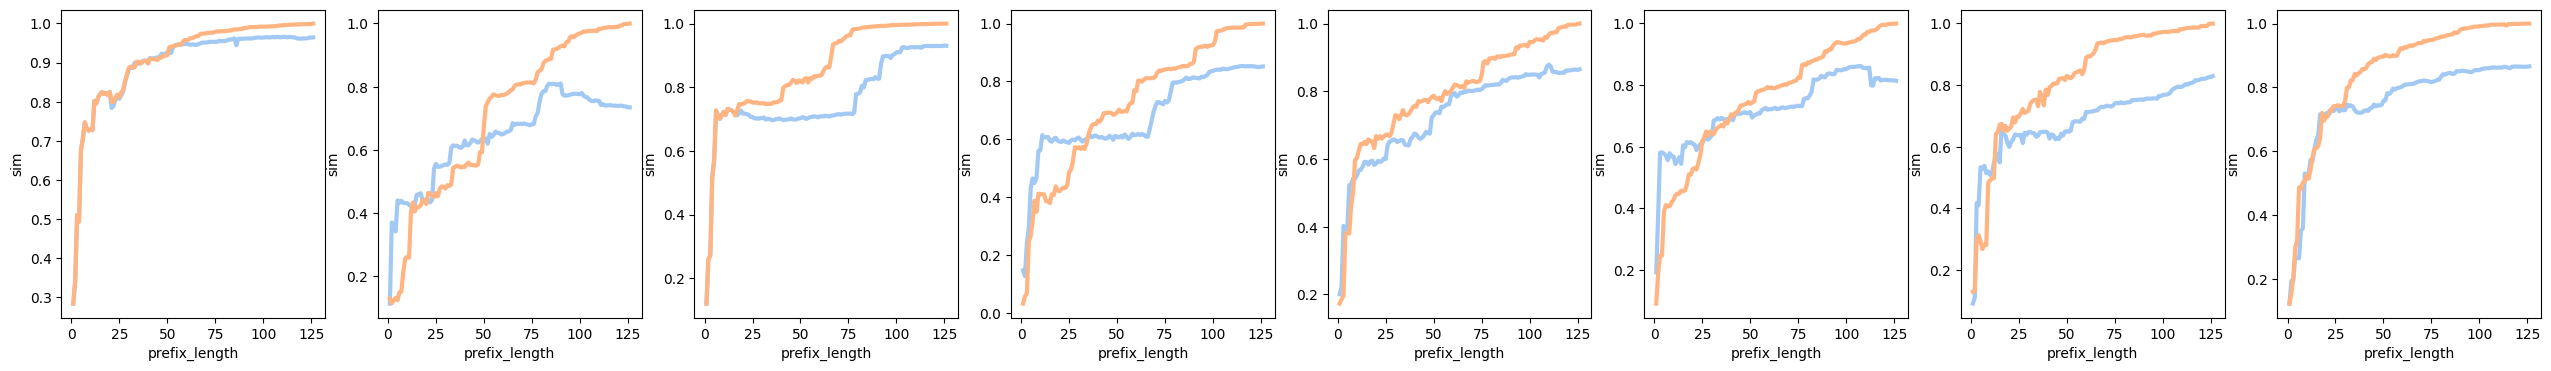

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(4*8, 4))

for i in range(8):
    pdf_i = df[df["i"] == i]
    sns.lineplot(ax=axes[i], data=pdf_i, x="prefix_length", y="sim", hue="ptype", legend=False, linewidth=3)